# Face blurring Application Using OpenCV DNN

We will use a face detection model to detect faces in an image and blur them.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read in the model
model = cv2.dnn.readNetFromCaffe('./model/deploy.prototxt',\
                                 './model/res10_300x300_ssd_iter_140000.caffemodel')

We want to see the output of the last layer. We do this by getting layer shapes using `getLayersShapes`. Note that in C++, there are other functions that enable you to get the shape for a specific layer.

In [3]:
layersIds, inLayersShapes, outLayersShapes = model.getLayersShapes((10, 3, 300, 300))

In [4]:
id = layersIds[-1]
print(str(id).ljust(5), inLayersShapes[id][0], outLayersShapes[id][0])

112   [   10 35568] [   1    1 2000    7]


We see that the output has a shape of `(1, 1, 200, 7)` for an initial input of 1 blob of size `(300, 300, 3)`. If we change the size of the blob, we notice that the shape of the input changes to `(1, 1, N * 200, 7)` with N being the number of blobs in the image.

We will begin by defining our face detection pipeline. This pipeline simply loads in an image, and returns the detected faces with a bounding box around them. Since we have done this in our streamlit face detection application, we will simply reference that.

Next, we define an elliptical blur functionality that draws an elliptical blur around the detected faces.

We will then scale this functionality to multiple blobs.

## 1. Detect Faces in an Image or Multiple Images

In [5]:
# Given a blob, detect faces and return, for each image in the blob,
# the coordinates of the face
def detectandmark(blob, model, frames : list, thresh_confidence = 0.5):
    """
    Given a blob, detect faces and return, for each image in the blob,
    the coordinates of the faces found.
    blob - could be one or more images
    model - face detection model
    frames - list of 2-value tuples describing each image H, W in that order
    threshold_value - minimum value below which a detection is not considered a face
    """
    assert(blob.shape[0] == len(frames)), "There must be as many frames as blob inputs!"

    model.setInput(blob)
    detections = model.forward()

    # will hold all the faces for the images
    images = []
    # go through the predictions
    no_of_frames = int(detections.shape[2]/200)
    
    for frame in range(no_of_frames):
        # get all the predictions done for the image
        preds_in_blobs = np.where(detections[0, 0, :, 0] == frame)[0]
        
        # store the coordinates of every face found in the frame
        faces_in_frame = []

        # size of the frame
        h, w, = frames[frame]
        
        for face in preds_in_blobs:
            #get confidence
            confidence = detections[0, 0, face, 2]
    
            if confidence >= thresh_confidence:
                #Take the coordinates
                box = (detections[0, 0, face, 3:7] * np.array([w, h, w, h])).astype(int)
            else:
                continue
            
            #append the face coordinates to the coordinates of the whole image
            faces_in_frame.append(box)
        images.append(faces_in_frame)
    return images

# by this time images has as many inputs as the number of images,
# each entry in images is the faces for each image, with each
# face as a dictionary containing the top and bottom bounding boxes.
# to get the first face in the first image images[0][0] will get the
# coordinates

Let us now test it out.

In [30]:
img1 = cv2.imread("../module_7/sample.jpg")
img2 = cv2.imread("../module_7/sample2.jpg")

In [7]:
#pass inference on the first image
blob1 = cv2.dnn.blobFromImage(img1,
                             scalefactor=1.0,
                             size=(300,300),
                             mean=(104.0, 177.0, 123.0))
faces_img1 = detectandmark(blob1, model, [img1.shape[:2]])

We can get the faces for the first image by taking index `0`.

In [8]:
faces_img1[0]

[array([1754, 2783, 2246, 3417]),
 array([ 897, 1234, 1380, 1788]),
 array([1320, 1644, 1833, 2297]),
 array([ 460, 1665, 1041, 2394]),
 array([2025, 1577, 2493, 2097]),
 array([1775, 1886, 2257, 2563]),
 array([2603, 1460, 3188, 2236])]

Let us now try passing multiple blobs and see how it will behave.

In [9]:
#pass inference on multiple images
blob2 = cv2.dnn.blobFromImages([img1, img2],
                              scalefactor=1.0,
                              size=(300,300),
                              mean=(104.0, 177.0, 123.0))

frames_all = [img1.shape[:2], img2.shape[:2]]
faces_all_images = detectandmark(blob2, model, frames_all)

To get the first face of the second image, we pass the index `[1][0]`.

In [10]:
faces_all_images[1][0]

array([1374,  711, 1832, 1289])

## A drawing function

We can detect images, but not much else. Let's implement a drawing function. We will use this as a building block to our blurring functionality.

In [11]:
def drawdetectedfaces(frame, faces):
    """
    This function draws all the faces in an image

    It expects a frame and a list of lists. Each internal list is a dictionary of face
    coordinates.
    
    It returns the frame, drawn
    """
    h, w = frame.shape[:2]
    frame2 = frame.copy()

    # define custom thickness
    custom_thickness = max(1, int(h/200))
    
    # drawing on the frame
    for face in faces:
        (x1, y1, x2, y2) = face
        cv2.rectangle(frame2,
                      (x1, y1),
                      (x2, y2),
                      color = (0, 255, 0),
                      thickness = custom_thickness)
    return frame2

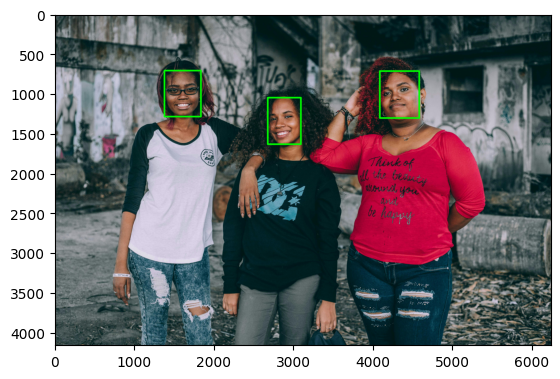

In [12]:
img2_drawn = drawdetectedfaces(img2, faces_all_images[1])
plt.imshow(img2_drawn[:, :, ::-1])

## A blurring Function

Now that we have our drawing function down, we can go on and implement our blurring functionality. We will first implement a box blur, we will then do an elliptical blur.

### Rectangular blur

In [13]:
def blur(face, factor=3):
    
    h, w  = face.shape[:2]

    if factor < 1: factor = 1 # Maximum blurring
    if factor > 5: factor = 5 # Minimal blurring
    
    # Kernel size.
    w_k = int(w/factor)
    h_k = int(h/factor)

    # Insure kernel is an odd number.
    if w_k%2 == 0: w_k += 1 
    if h_k%2 == 0: h_k += 1 

    blurred = cv2.GaussianBlur(face, (w_k, h_k), 0, 0)
    return blurred

In [14]:
def blurdetectedfaces(frame, faces):
    """
    This function blurs all the faces in 'faces' in the
    image 'frame'.
    
    It expects a frame and a list of faces.    
    It returns the frame, drawn
    """
    frame2 = frame.copy()
    # blurring on the frame
    for coord in faces:
        (x1, y1, x2, y2) = coord
        face = frame2[y1:y2, x1:x2]
        blurred_face = blur(face)

        frame2[y1:y2, x1:x2] = blurred_face
    return frame2

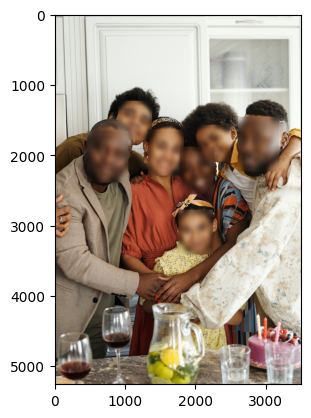

In [15]:
img1_blurred = blurdetectedfaces(img1, faces_all_images[0])
plt.imshow(img1_blurred[:, :, ::-1])

### Elliptical Blur

First, we construct an ellipse from the face coordinates. We then apply a rectangular blur to the image. We then add the blur and the elliptical mask and return to the image.

In [67]:
def elliptical_blur(face, factor=3):
    
    h, w  = face.shape[:2]
    face_copy = face.copy()

    if factor < 1: factor = 1 # Maximum blurring
    if factor > 5: factor = 5 # Minimal blurring
    
    # Kernel size.
    w_k = int(w/factor)
    h_k = int(h/factor)

    # Insure kernel is an odd number.
    if w_k%2 == 0: w_k += 1 
    if h_k%2 == 0: h_k += 1 

    box_blurred = cv2.GaussianBlur(face, (w_k, h_k), 0, 0)
    
    # draw ellipse
    e_centre = (w/2, h/2)
    ellipse = cv2.ellipse(np.zeros_like(face), (e_centre, (w,h), 0.0), (255, 255, 255), -1, cv2.LINE_AA)

    faces = cv2.bitwise_and(box_blurred, ellipse)
    face_mask = cv2.bitwise_and(face, face, mask = cv2.bitwise_not(ellipse[:, :, 0]))

    return face_mask + faces

In [19]:
def blurfaces_elliptic(frame, faces):
    """
    This function blurs all the faces in 'faces' in the
    image 'frame'.
    
    It expects a frame and a list of faces.    
    It returns the frame, drawn
    """
    frame2 = frame.copy()
    # blurring on the frame
    for coord in faces:
        (x1, y1, x2, y2) = coord
        face = frame2[y1:y2, x1:x2]

        frame2[y1:y2, x1:x2] = elliptical_blur(face)
    return frame2

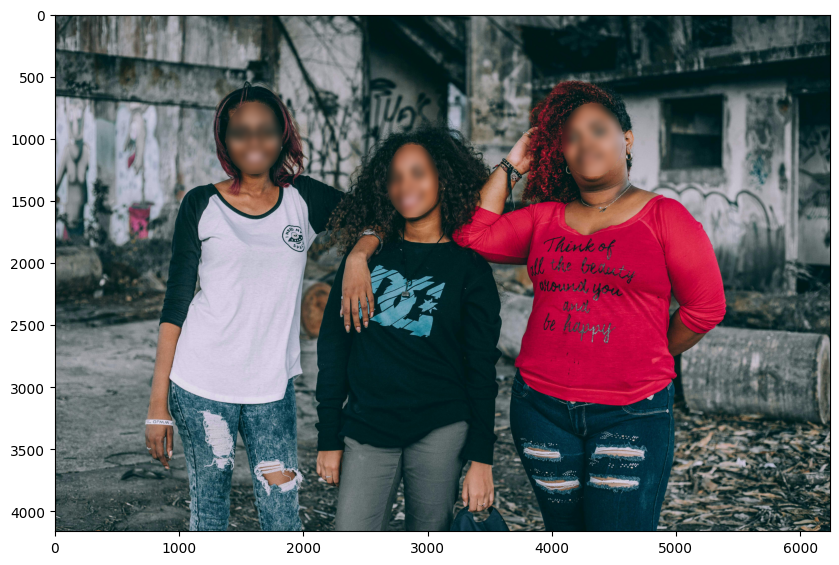

In [68]:
img2_blurred = blurfaces_elliptic(img2, faces_all_images[1])
plt.figure(figsize=[10, 10])
plt.imshow(img2_blurred[:, :, ::-1])

There we have it. An elliptical blur.